# Week 2 – Classification 
## Overfitting, Regularization, and Regularized Regression

In this notebook we will:

1. Understand **underfitting** and **overfitting**.
2. Introduce **regularization** as a way to control model complexity.
3. Define the **cost function with regularization** and its **derivatives**.
4. Implement **regularized linear regression**.
5. Implement **regularized logistic regression**.

Notation (consistent with Hour 1):

- Vectors (conceptual): $\vec{w}, \vec{x}$.
- Linear regression hypothesis:  
  $$
  f_{\vec{w}, b}(\vec{x}) = \vec{w} \cdot \vec{x} + b.
  $$
- Logistic regression hypothesis:  
  $$
  f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b).
  $$
- For sample $i$:  
  $$
  f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = f_{\vec{w}, b}(\vec{x}^{(i)}).
  $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

## 1. Underfitting and Overfitting

Consider a simple **regression** problem: predict $y$ from $x$.  
Suppose the true relationship is **nonlinear** (for example, a sine wave).

We can choose different models:

- **Underfitting**: model is too simple (e.g., a straight line).
- **Good fit**: model captures the main pattern without memorizing noise.
- **Overfitting**: model is too complex and memorizes noise/outliers.

We will illustrate this using **polynomial regression**:

- Degree 1: underfitting.
- Degree 3: reasonable fit.
- Degree 10: overfitting.


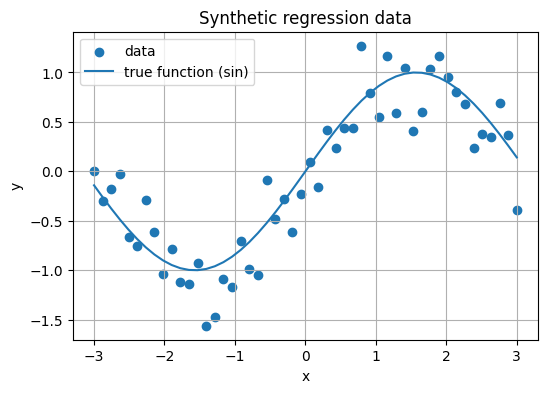

In [2]:
# Generate synthetic 1D regression data
np.random.seed(42)
m = 50
X_scalar = np.linspace(-3, 3, m)
y_true = np.sin(X_scalar)
noise = 0.3 * np.random.randn(m)
y = y_true + noise

plt.figure()
plt.scatter(X_scalar, y, label="data")
plt.plot(X_scalar, y_true, label="true function (sin)")
plt.title("Synthetic regression data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [3]:
def make_poly_features(x, degree):
    """Create polynomial features [x, x^2, ..., x^degree] for 1D input x."""
    X_list = []
    for d in range(1, degree + 1):
        X_list.append(x ** d)
    return np.vstack(X_list).T  # shape (m, degree)

In [4]:
def fit_linear_regression_closed_form(X, y):
    """Fit linear regression using the normal equation (no regularization)."""
    # Add a column of ones for the bias term
    m = X.shape[0]
    X_bias = np.column_stack([X, np.ones(m)])  # last column is for b
    
    # Solve [w; b] = (X^T X)^-1 X^T y
    theta = np.linalg.pinv(X_bias.T @ X_bias) @ (X_bias.T @ y)
    w = theta[:-1]
    b = theta[-1]
    return w, b


def predict_linear(w, b, X):
    return X @ w + b

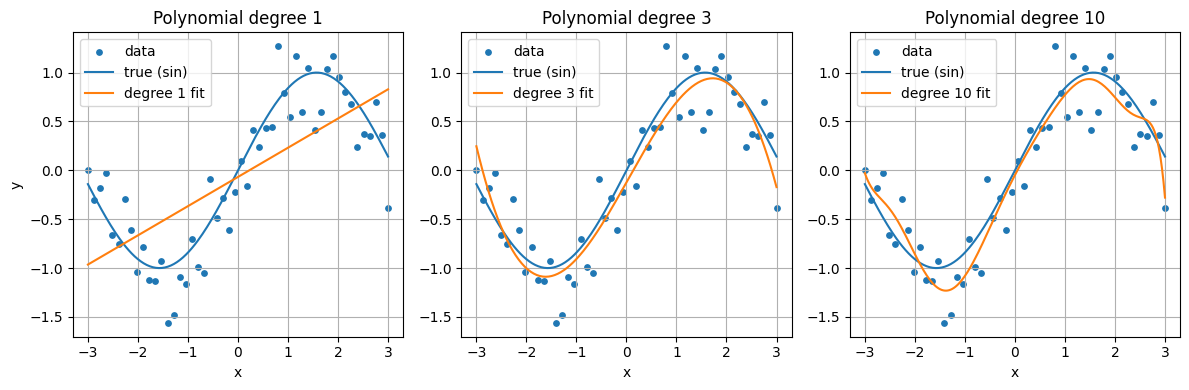

In [5]:
degrees = [1, 3, 10]
x_plot = np.linspace(-3, 3, 200)
y_true_plot = np.sin(x_plot)  # true function on dense grid

plt.figure(figsize=(12, 4))

for i, deg in enumerate(degrees):
    X_poly = make_poly_features(X_scalar, deg)
    w, b = fit_linear_regression_closed_form(X_poly, y)
    
    X_plot_poly = make_poly_features(x_plot, deg)
    y_plot = predict_linear(w, b, X_plot_poly)
    
    plt.subplot(1, 3, i+1)
    plt.scatter(X_scalar, y, label="data", s=15)
    plt.plot(x_plot, y_true_plot, label="true (sin)")
    plt.plot(x_plot, y_plot, label=f"degree {deg} fit")
    plt.title(f"Polynomial degree {deg}")
    plt.xlabel("x")
    if i == 0:
        plt.ylabel("y")
    plt.legend()

plt.tight_layout()
plt.show()

In the plots:

- **Degree 1** (left): the model is too simple → it **underfits** the data.  
- **Degree 3** (middle): the model follows the main trend → **good generalization**.  
- **Degree 10** (right): the model wiggles and follows noise → it **overfits**.

**Goal:** Control model complexity to avoid overfitting.  
One key tool: **regularization**.


## 2. Regularization

Idea: penalize **large parameters** so the model prefers **simpler** solutions.

For a parameter vector $\vec{w} = (w_1, \dots, w_n)$, we define the **L2 regularization term**:

$$
R(\vec{w}) = \sum_{j=1}^n w_j^2.
$$

We **do not** include the bias $b$ in this penalty (only the weights).

Regularization adds this penalty to the original cost function, controlled by a
hyperparameter $\lambda \ge 0$:

- $\lambda = 0$: no regularization (risk of overfitting).
- Large $\lambda$: strong penalty (risk of underfitting).
- Intermediate $\lambda$: good compromise.


## 3. Cost Function with Regularization

### 3.1 Regularized Linear Regression

For linear regression we had (without regularization):

$$
J(\vec{w}, b) =
\frac{1}{2m}\sum_{i=1}^m
\left(
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
\right)^2,
$$

with
$$
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = \vec{w}\cdot\vec{x}^{(i)} + b.
$$

We now add the **L2 regularization term**:

$$
J_{\text{reg}}(\vec{w}, b) =
\frac{1}{2m}\sum_{i=1}^m
\left(
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
\right)^2
+
\frac{\lambda}{2m}\sum_{j=1}^n w_j^2.
$$

Note: the sum over $j$ runs only over the components of $\vec{w}$, not $b$.

### 3.2 Regularized Logistic Regression

For logistic regression, the **unregularized** cost was:

$$
J(\vec{w}, b) =
-\frac{1}{m}
\sum_{i=1}^m
\left[
y^{(i)} \log f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) \;+\;
(1 - y^{(i)}) \log\big(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\big)
\right],
$$

with
$$
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = \sigma(\vec{w}\cdot\vec{x}^{(i)} + b).
$$

The **regularized** cost is:

$$
J_{\text{reg}}(\vec{w}, b) =
-\frac{1}{m}
\sum_{i=1}^m
\left[
y^{(i)} \log f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) \;+\;
(1 - y^{(i)}) \log\big(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\big)
\right]
+
\frac{\lambda}{2m}\sum_{j=1}^n w_j^2.
$$


### 3.3 Gradients for Regularized Linear Regression

Recall:
$$
J_{\text{reg}}(\vec{w}, b) =
\frac{1}{2m}\sum_{i=1}^m
\left(
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
\right)^2
+
\frac{\lambda}{2m}\sum_{j=1}^n w_j^2,
$$
with
$$
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = \vec{w}\cdot\vec{x}^{(i)} + b.
$$

Define the error for each example:
$$
e^{(i)} = f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}.
$$

Then, for each weight $w_j$:
$$
\frac{\partial J_{\text{reg}}}{\partial w_j}
=
\frac{1}{m}\sum_{i=1}^m e^{(i)} x^{(i)}_j
+
\frac{\lambda}{m} w_j,
$$

and for the bias:
$$
\frac{\partial J_{\text{reg}}}{\partial b}
=
\frac{1}{m}\sum_{i=1}^m e^{(i)}.
$$

These are the derivatives used in **gradient descent**:
$$
w_j := w_j - \alpha \frac{\partial J_{\text{reg}}}{\partial w_j},
\quad
b := b - \alpha \frac{\partial J_{\text{reg}}}{\partial b}.
$$


In [9]:
def compute_cost_lin_reg_reg(w, b, X, y, lam):
    """Regularized linear regression cost J_reg(w, b)."""
    m, n = X.shape
    preds = X @ w + b  # f_{w,b}^{(i)}(x^{(i)})
    errors = preds - y
    mse_term = (1 / (2 * m)) * np.sum(errors ** 2)
    reg_term = (lam / (2 * m)) * np.sum(w ** 2)
    return mse_term + reg_term


def compute_gradient_lin_reg_reg(w, b, X, y, lam):
    """Gradient of regularized linear regression cost w.r.t w and b."""
    m, n = X.shape
    preds = X @ w + b
    errors = preds - y
    
    dj_dw = (1 / m) * (X.T @ errors) + (lam / m) * w
    dj_db = (1 / m) * np.sum(errors)
    return dj_dw, dj_db


def gradient_descent_lin_reg_reg(X, y, w_init, b_init, alpha, lam, num_iters):
    w = w_init.copy()
    b = b_init
    J_history = []
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_lin_reg_reg(w, b, X, y, lam)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        J_history.append(compute_cost_lin_reg_reg(w, b, X, y, lam))
    return w, b, J_history

For **regularized linear regression**, there is a **closed-form analytical solution**, known as **ridge regression**. 

Compared to gradient descent, the ridge closed-form solution has sveral advantages:

- Is **exact** (for this cost function): we obtain the global minimizer directly.
- Has **no learning rate** to tune.
- Is **numerically stable** for polynomial features of moderate degree.
- Produces **predictable, clean plots**:
  - $\lambda = 0$: strong overfitting (wiggly curve),
  - Intermediate $\lambda$: controlled complexity,
  - Large $\lambda$: underfitting (almost linear).

For our polynomial regression demo, this is ideal:  
students can clearly see the effect of **the same degree, different $\lambda$** on the shape of the curve.

The ridge closed-form method also has limitations:

- It requires computing the inverse (or pseudo-inverse) of a $(n+1) \times (n+1)$ matrix.
  - This is fine for small or moderate $n$,
  - But can be expensive when $n$ is very large.
- It only exists for **linear models** with quadratic costs.
  - There is no closed-form solution for logistic regression,
  - Nor for neural networks and most deep learning models.

So, while perfect for our **regularized linear regression demo**, it is **not a general replacement** for gradient descent.

The code above shows the implementation of gradient descent with regularization. However, for the demo we use the ridge regression method defined below. You can find a detailed explanation in the apendix [here.](./APENDIX-RidgeVsGradientDescentInRegularizedLinearRegression.ipynb)


In [10]:
def fit_linear_regression_ridge(X, y, lam):
    """
    Closed-form ridge regression:
    minimize (1/(2m)) ||Xw + b - y||^2 + (lam/(2m)) ||w||^2
    We do NOT regularize the bias term.
    """
    m, n = X.shape
    # Add bias column
    X_bias = np.column_stack([X, np.ones(m)])  # shape (m, n+1)

    # Identity for regularization (do not regularize bias -> last entry = 0)
    I = np.eye(n + 1)
    I[-1, -1] = 0.0

    # Ridge solution: theta = (X^T X + lam * I)^(-1) X^T y
    theta = np.linalg.pinv(X_bias.T @ X_bias + lam * I) @ (X_bias.T @ y)
    w = theta[:-1]
    b = theta[-1]
    return w, b


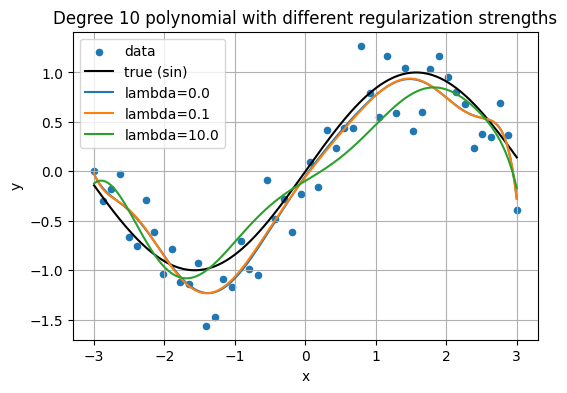

In [11]:

# Compare fits for degree 10 polynomial with different lambda values (closed-form ridge)

degree = 10
X_poly_high = make_poly_features(X_scalar, degree)  # features built on original x
x_plot = np.linspace(-3, 3, 200)
X_plot_poly_high = make_poly_features(x_plot, degree)
y_true_plot = np.sin(x_plot)

lambdas = [0.0, 0.1, 10.0]
colors = ["tab:blue", "tab:orange", "tab:green"]

plt.figure()
plt.scatter(X_scalar, y, label="data", s=20)
plt.plot(x_plot, y_true_plot, "k-", label="true (sin)")

for lam, col in zip(lambdas, colors):
    w_reg, b_reg = fit_linear_regression_ridge(X_poly_high, y, lam)
    y_plot_reg = X_plot_poly_high @ w_reg + b_reg
    plt.plot(x_plot, y_plot_reg, color=col, label=f"lambda={lam}")

plt.title("Degree 10 polynomial with different regularization strengths")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()




In the plot above (degree 10 polynomial):

- **$\lambda = 0$**: no regularization → the curve **overfits** strongly.
- **Small $\lambda$ (e.g., 0.1)**: the curve is smoother and follows the main trend.
- **Large $\lambda$ (e.g., 10)**: the curve becomes almost linear or too simple → risk of **underfitting**.

Regularization **shrinks** the parameters $w_j$ toward zero and controls complexity.


## 4. Regularized Logistic Regression

We now implement **regularized logistic regression**.

Recall the (unregularized) hypothesis:
$$
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = \sigma(\vec{w} \cdot \vec{x}^{(i)} + b).
$$

Regularized cost:
$$
J_{\text{reg}}(\vec{w}, b) =
-\frac{1}{m}
\sum_{i=1}^m
\left[
y^{(i)} \log f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) \;+\;
(1 - y^{(i)}) \log\big(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\big)
\right]
+
\frac{\lambda}{2m}\sum_{j=1}^n w_j^2.
$$


### 4.1 Gradients for Regularized Logistic Regression

For each example:
$$
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = \sigma(\vec{w}\cdot\vec{x}^{(i)} + b).
$$

Define the error:
$$
e^{(i)} = f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}.
$$

Then the gradients of the regularized cost are:

For each weight $w_j$:
$$
\frac{\partial J_{\text{reg}}}{\partial w_j}
=
\frac{1}{m}\sum_{i=1}^m e^{(i)} x^{(i)}_j
+
\frac{\lambda}{m} w_j,
$$

and for the bias:
$$
\frac{\partial J_{\text{reg}}}{\partial b}
=
\frac{1}{m}\sum_{i=1}^m e^{(i)}.
$$

Gradient descent updates are:

$$
w_j := w_j - \alpha \frac{\partial J_{\text{reg}}}{\partial w_j},
\quad
b := b - \alpha \frac{\partial J_{\text{reg}}}{\partial b}.
$$


In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_cost_log_reg_reg(w, b, X, y, lam):
    """Regularized logistic regression cost."""
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)  # f_{w,b}^{(i)}(x^{(i)})
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)
    # Cross-entropy term
    ce = - (1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    # Regularization term
    reg = (lam / (2 * m)) * np.sum(w ** 2)
    return ce + reg


def compute_gradient_log_reg_reg(w, b, X, y, lam):
    """Gradient of regularized logistic regression cost."""
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    error = f - y  # f_{w,b}^{(i)}(x^{(i)}) - y^{(i)}
    dj_dw = (1 / m) * (X.T @ error) + (lam / m) * w
    dj_db = (1 / m) * np.sum(error)
    return dj_dw, dj_db


def gradient_descent_log_reg_reg(X, y, w_init, b_init, alpha, lam, num_iters):
    w = w_init.copy()
    b = b_init
    J_history = []
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_log_reg_reg(w, b, X, y, lam)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        J_history.append(compute_cost_log_reg_reg(w, b, X, y, lam))
    return w, b, J_history

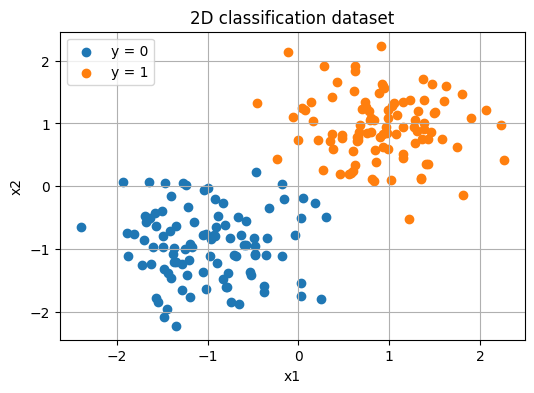

In [14]:
# Create a simple 2D classification dataset (two clusters)
np.random.seed(0)
m_class = 200
mean0 = np.array([-1.0, -1.0])
mean1 = np.array([1.0, 1.0])
cov = 0.3 * np.eye(2)

X0 = np.random.multivariate_normal(mean0, cov, m_class // 2)
X1 = np.random.multivariate_normal(mean1, cov, m_class // 2)
X_class = np.vstack([X0, X1])
y_class = np.hstack([np.zeros(m_class // 2), np.ones(m_class // 2)])

plt.figure()
plt.scatter(X_class[y_class == 0, 0], X_class[y_class == 0, 1], label="y = 0")
plt.scatter(X_class[y_class == 1, 0], X_class[y_class == 1, 1], label="y = 1")
plt.title("2D classification dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

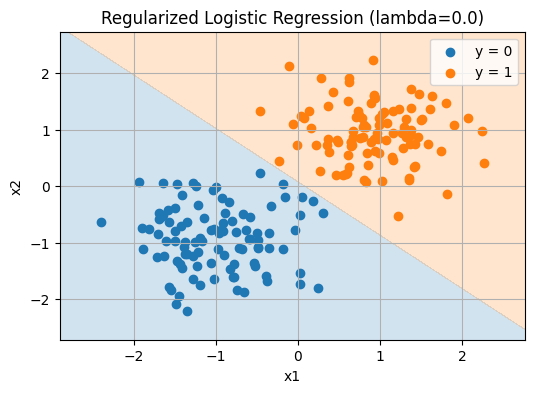

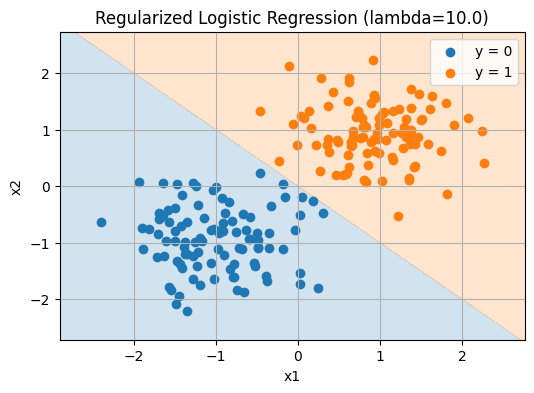

In [15]:
def plot_decision_boundary_logreg(w, b, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    z = grid @ w + b
    probs = sigmoid(z).reshape(xx.shape)
    
    plt.figure()
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["tab:blue", "tab:orange"])
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="y = 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="y = 1")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()


# Compare no regularization vs regularization
lambdas = [0.0, 10.0]
for lam in lambdas:
    w0 = np.zeros(2)
    b0 = 0.0
    w_reg, b_reg, J_hist = gradient_descent_log_reg_reg(
        X_class, y_class, w0, b0, alpha=0.5, lam=lam, num_iters=300
    )
    plot_decision_boundary_logreg(
        w_reg, b_reg, X_class, y_class, title=f"Regularized Logistic Regression (lambda={lam})"
    )

## Summary (Hour 2)

In this notebook we:

1. Visualized **underfitting** and **overfitting** using polynomial regression.
2. Introduced **L2 regularization** to penalize large weights:
   $$
   R(\vec{w}) = \sum_{j=1}^n w_j^2.
   $$
3. Defined **regularized cost functions** and their **derivatives**:
   - For linear regression:
     $$
     J_{\text{reg}}(\vec{w}, b) =
     \frac{1}{2m}\sum_{i=1}^m
     \left(
     f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
     \right)^2
     + \frac{\lambda}{2m}\sum_{j=1}^n w_j^2,
     $$
     $$
     \frac{\partial J_{\text{reg}}}{\partial w_j}
     =
     \frac{1}{m}\sum_{i=1}^m e^{(i)} x^{(i)}_j
     +
     \frac{\lambda}{m} w_j,
     \quad
     \frac{\partial J_{\text{reg}}}{\partial b}
     =
     \frac{1}{m}\sum_{i=1}^m e^{(i)}.
     $$
   - For logistic regression:
     $$
     J_{\text{reg}}(\vec{w}, b) =
     -\frac{1}{m}
     \sum_{i=1}^m
     \left[
     y^{(i)} \log f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) \;+\;
     (1 - y^{(i)}) \log\big(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\big)
     \right]
     +
     \frac{\lambda}{2m}\sum_{j=1}^n w_j^2,
     $$
     with analogous gradients:
     $$
     \frac{\partial J_{\text{reg}}}{\partial w_j}
     =
     \frac{1}{m}\sum_{i=1}^m e^{(i)} x^{(i)}_j
     +
     \frac{\lambda}{m} w_j,
     \quad
     \frac{\partial J_{\text{reg}}}{\partial b}
     =
     \frac{1}{m}\sum_{i=1}^m e^{(i)}.
     $$
4. Implemented **regularized linear regression** and saw how $\lambda$ affects the fit of a high-degree polynomial.
5. Implemented **regularized logistic regression** and visualized decision boundaries with and without regularization.

These derivations make explicit how **gradient descent** is applied when we include
regularization in both linear and logistic regression.
